# Visualizing results of onine meta analyses of the same topic

I searched for the term "decision making" in these two websites, and downloaded the results:
- NeuroSynth: https://neuroquery.saclay.inria.fr/ 
- NeuroQuery: https://neuroquery.saclay.inria.fr/ 


In [1]:
import warnings
warnings.filterwarnings("ignore")
import functions as fun # functions mostly written by Alexendre Perez
from nistats import thresholding
import numpy as np
import nibabel as nib
import nibabel.processing
import nilearn
from nilearn import masking, plotting, image
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats as st
from netneurotools import stats as nnstats
from netneurotools import datasets as nndata

from brainspace.null_models import SpinPermutations
from brainspace.plotting import plot_hemispheres

template = nilearn.datasets.load_mni152_template()
affine = template.affine

level = .05
height_control = 'fdr'
cluster_threshold = 1
sample_size=119

%matplotlib inline
cut_coords=(0, 0, 0)
save_figs = True
font_size = 12

hypothesis = 2

## Get consensus result with meta-analysis of level-2 maps

### Get data ready for OLS

In [2]:
input_dir = '../data-narps/proc/'
img_paths = fun.get_data_paths_from_orig('hypo%d_unthresh.nii.gz' %hypothesis)
# N_img = 5
# img_paths = img_paths[:N_img]

Get level-2 maps (outcome variable)

In [3]:
order = 'C'
for n, path in enumerate(img_paths):
    img = nilearn.image.load_img(path)
    img_resampled = image.resample_to_img(img, template)
    array = img_resampled.get_fdata()
    flat = array.ravel(order=order)
    flat = np.array(flat)
    flat = np.expand_dims(flat, axis=1)
    if n == 0:
        y = flat
        voxel_to_plot = np.argmax(flat)
    else:
        y = np.concatenate((y, flat), axis=1)
y=y.T
Y = np.matrix(y)
Y = np.nan_to_num(Y, copy=False, nan=0)

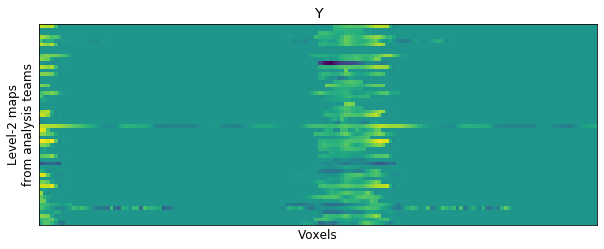

In [4]:
font = {'size'   : font_size}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(10,5))
plt.imshow(Y[:, voxel_to_plot: voxel_to_plot+150])
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
plt.title('Y')
plt.xlabel('Voxels')
plt.ylabel('Level-2 maps\nfrom analysis teams')

if save_figs: plt.savefig('../figures/final_figures_paper/methods2A_Y-in-glm.png')

Make design matrix (column of ones)

In [5]:
x = np.ones_like(y[:,0])
X = np.matrix(x).T

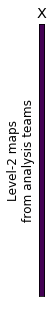

In [6]:
fig, ax = plt.subplots(figsize=(1,5))
plt.imshow(np.expand_dims(x, axis=1))
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
plt.title('X')
plt.xlabel(' ')
plt.ylabel('Level-2 maps\nfrom analysis teams')
if save_figs: plt.savefig('../figures/final_figures_paper/methods2A_X-in-glm.png')

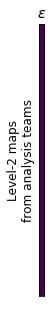

In [7]:
fig, ax = plt.subplots(figsize=(1,5))
plt.imshow(np.expand_dims(x, axis=1))
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])
plt.title('$\epsilon$')
plt.xlabel(' ')
plt.ylabel('Level-2 maps\nfrom analysis teams')
if save_figs: plt.savefig('../figures/final_figures_paper/methods2A_Error-in-glm.png')

### OLS

In [8]:
# Estimate parameters using OLS
betas = ((X.T * X)**-1) * X.T * Y

# Calculate standard error map
n = Y.shape[0]
residual = np.array(Y - X*betas)
SSE = np.squeeze(np.sum(np.power(residual,2), axis=0))
SD = np.sqrt(SSE/(n-1))
SE = SD/np.sqrt(n)

# Calculate z-map using Fisher's transformation from r-values to z-values 
# (the betas are pearson's r values because there's only one predictor)
zs = np.arctanh(betas)

# Calculate t-map
ts = betas/SE

Convert to nifti images so they can be visualized

In [9]:
SE_nii = fun.flat_mat_to_nii(flat_mat=SE, ref_niimg=img_resampled, order=order)
betas_nii = fun.flat_mat_to_nii(flat_mat=betas, ref_niimg=img_resampled, order=order)
L3_z_nii = fun.flat_mat_to_nii(flat_mat=zs, ref_niimg=img_resampled, order=order)
L3_t_nii = fun.flat_mat_to_nii(flat_mat=ts, ref_niimg=img_resampled, order=order)

In [10]:
# threshold the t-map
L3_t_nii_thresh = thresholding.map_threshold(L3_t_nii, alpha=level,
                                            height_control=height_control,
                                            cluster_threshold=cluster_threshold)[0]

### Visualize

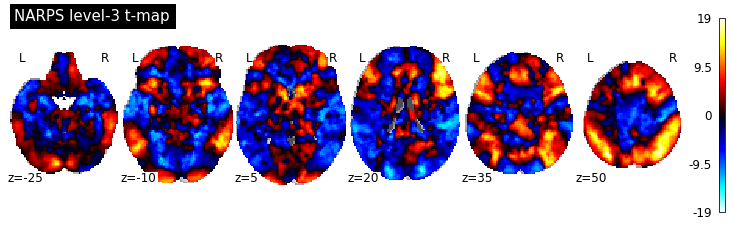

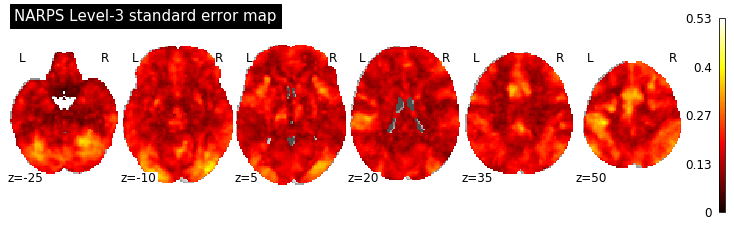

In [11]:
cut_coords = np.arange(-25, 65, 15)
brain_fig_size = [10, 3]
font = {'size'   : 12}
matplotlib.rc('font', **font)

maps = { 
    #'NARPS Level-3 beta map': betas_nii,
    #'NARPS Level-3 z-map': L3_z_nii,
    'NARPS level-3 t-map': L3_t_nii,
    'NARPS Level-3 standard error map': SE_nii,
    #'NARPS Level-3 t-map - thresholded': L3_t_nii_thresh,
}
for name, img in maps.items():
    plotting.plot_stat_map(fun.mni_mask(img), 
                          title=name,
                          display_mode='z', 
                          cut_coords=cut_coords,
                          figure=plt.figure(figsize=brain_fig_size))
    
    
    if save_figs: plt.savefig('../figures/final_figures_paper/results2A_hypo%d_%s.png'\
                                  %(hypothesis, name.replace(' ', '-')))

## Compare to online meta-analytic results

### Load NeuroQuery result

In [12]:
NQ_z_path = '../data-narps/NQ_loss_aversion_in_decisionmaking_under_risk.nii.gz'
NQ_z_nii_nii = thresholding.map_threshold(NQ_z_path, alpha=level,
                               height_control=height_control,
                               cluster_threshold=cluster_threshold)[0]

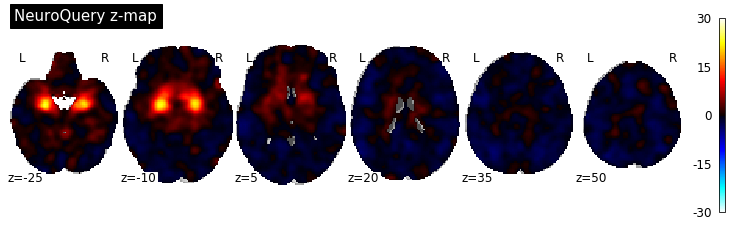

In [13]:
name = 'NeuroQuery z-map'
img = NQ_z_path
plotting.plot_stat_map(fun.mni_mask(img), display_mode='z', cut_coords=cut_coords,
                          figure=plt.figure(figsize=brain_fig_size), title=name)
    
if save_figs: plt.savefig('../figures/final_figures_paper/results2A_hypo%d_%s.png'\
                                  %(hypothesis, name.replace(' ', '-')))

### Convert volumes to surfaces so that we can use a spin test
So that the spin test can be used to test the significance of the similarity between maps (the spin test works on surfaces)

In [14]:
# sample the 3D volume data onto a surface mesh
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage('fsaverage5') #('fsaverage') # cortical mesh

from nilearn import surface
def get_surface(vol_path, hemi):
    if hemi == 'left': surf_mesh = fsaverage.pial_left
    if hemi == 'right': surf_mesh = fsaverage.pial_right
    surf = surface.vol_to_surf(img=vol_path, surf_mesh=surf_mesh, mask_img=template)
    surf = np.nan_to_num(surf, nan=0)
    if len(surf.shape) < 2: surf = np.expand_dims(np.array(surf), axis=1)
    return surf
    
# level-3 results
L3_L = get_surface(L3_z_nii, hemi='left')
L3_R = get_surface(L3_z_nii, hemi='right')

# neuroquery results
NQ_L = get_surface(NQ_z_path, hemi='left')
NQ_R = get_surface(NQ_z_path, hemi='right')

# level-2 results
for n, path in enumerate(img_paths):
    L = get_surface(path, hemi='left')
    R = get_surface(path, hemi='right')
    if n == 0:
        L2s_L = L
        L2s_R = R
        vertex = np.argmax(L) # for selecting vertices to plot
        
        L2s_B = np.concatenate([L, R], axis=0)
    else:
        L2s_L = np.concatenate((L, L2s_L), axis=1)
        L2s_R = np.concatenate((R, L2s_R), axis=1)
        
        B = np.concatenate([L, R], axis=0)
        L2s_B = np.concatenate((B, L2s_B), axis=1)
        

## Measure similarity between level-3 consensus results & NeuroQuery results

### Spearman's correlation

In [15]:
# concatenate hemispheres
L3 = np.concatenate((L3_R, L3_L), axis=0)
NQ = np.concatenate((NQ_R, NQ_L), axis=0)

# whole brain
rs_NQ_L3, p_rs_NQ_L3 = st.spearmanr(a=NQ, b=L3, axis=0, nan_policy='omit')

# hemispheres separate
rs_NQ_L3_L = st.spearmanr(a=NQ_L, b=L3_L, axis=0, nan_policy='omit')[0]
rs_NQ_L3_R = st.spearmanr(a=NQ_R, b=L3_R, axis=0, nan_policy='omit')[0]

# results
print(rs_NQ_L3, rs_NQ_L3_L, rs_NQ_L3_R)

-0.08538743266660401 -0.08688990718667917 -0.09560942452366775


### Evaluate significance of similarity using a spin test 
(code based on netneurotools example)

First, we'll grab the spherical projections of the fsaverage5 surface and extract the vertex coordinates:

In [16]:
# if you have FreeSurfer installed on your computer this will simply grab the
# relevant files from the $SUBJECTS_DIR directory; otherwise, it will download
# them to the $HOME/nnt-data/tpl-fsaverage directory
lhsphere, rhsphere = nndata.fetch_fsaverage('fsaverage5', verbose=0)['sphere']
sphere_lh, lhface = nib.freesurfer.read_geometry(lhsphere)
sphere_rh, rhface = nib.freesurfer.read_geometry(rhsphere)
sphere_b = np.concatenate([sphere_lh, sphere_rh])

In [17]:
L3_L = np.squeeze(L3_L)
L3_R = np.squeeze(L3_R)
NQ_L = np.squeeze(NQ_L)
NQ_R = np.squeeze(NQ_R)
L3_B = np.concatenate([L3_L, L3_R])
NQ_B = np.concatenate([NQ_L, NQ_R])

In [18]:
# Let's create some rotations
n_permutations = 1000

sp = SpinPermutations(n_rep=n_permutations, random_state=0)
sp.fit(sphere_lh, points_rh=sphere_rh)

NQ_B_rotated = np.hstack(sp.randomize(NQ_L, NQ_R))

In [19]:
feats = {'NeuroQuery': NQ_B}
rotated = {'NeuroQuery': NQ_B_rotated}

r_spin = np.empty(n_permutations)
mask = ~np.isnan(NQ_B)
for fn, feat in feats.items():
    r_orig, pv_orig = st.spearmanr(feat[mask], L3_B[mask])

    for i, perm in enumerate(rotated[fn]):
        mask_rot = mask & ~np.isnan(perm)  # Remove non-cortex
        r_spin[i] = st.spearmanr(perm[mask_rot], L3_B[mask_rot])[0]
    pv_spin = np.mean(np.abs(r_spin) > np.abs(r_orig))

    print('{0}:\n Obs : {1:.5e}\n Spin: {2:.5e}\n'.
          format(fn.capitalize(), pv_orig, pv_spin))

Neuroquery:
 Obs : 1.84348e-34
 Spin: 1.02000e-01



### Similarity between level-2 results & NeuroQuery results, for each analysis team

In [20]:
r2s_NQ_L2s = []
rs_NQ_L2s = []

for n_team in range(len(img_paths)):
    L2_B = L2s_B[:, n_team]
    rs = st.spearmanr(a=L2_B, b=NQ_B, nan_policy='omit', axis=1)[0]
    rs_NQ_L2s.append(rs)
    r2s_NQ_L2s.append(rs*rs)

### VIsualize

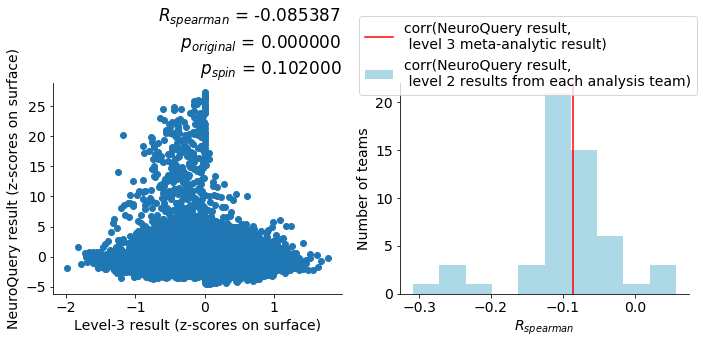

In [22]:
from matplotlib.gridspec import GridSpec

font_size = 14
letter_font_size = 25
font = {'size'   : font_size}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(10,5))
gs = GridSpec(1,2, figure=fig)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

ax1.scatter(L3, NQ)
ax1.set_xlabel('Level-3 result (z-scores on surface)')
ax1.set_ylabel('NeuroQuery result (z-scores on surface)')
ax1.set_title('$R_{spearman}$ = %f \n $p_{original}$ = %f \n $p_{spin}$ = %f' \
          %(rs_NQ_L3, p_rs_NQ_L3, pv_spin), loc='right')
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.tight_layout()
   

ma_nqs = {#'Pearson correlation': rp_ma_nq,
        'Spearman correlation': rs_NQ_L3}

teams_nqs = {#'Pearson correlation': rp_teams_nq,
           'Spearman correlation': rs_NQ_L2s}

for name in ma_nqs:
    ma_nq = ma_nqs[name]
    team_nq = teams_nqs[name]
    
    ax2.hist(team_nq, color='lightblue',
             label='corr(NeuroQuery result, \n level 2 results from each analysis team)')

    ax2.axvline(x=ma_nq, color='red', label='corr(NeuroQuery result, \n level 3 meta-analytic result)')
    ax2.legend(loc='best', bbox_to_anchor=(0., 0., 1.05, 1.35))

    #plt.xlim(-0.2,.2)
    ax2.set_xlabel('$R_{spearman}$')
    ax2.set_ylabel('Number of teams')
    #plt.title(name)

    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
plt.tight_layout()


fig_name = '../figures/final_figures_paper/results2B_hypo%d_corr_with_NQ.png' %hypothesis
if save_figs: plt.savefig(fig_name, bbox_inches="tight")
    